In [1]:
# Import libraries
# For dl modeling
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# For number crunching
import numpy as np

# For data management
import pandas as pd

# For visualisation
import matplotlib.pyplot as plt

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, sep = ';')

In [3]:
data = data[data['total sulfur dioxide'] < 200]
data['boolQuality'] = 0
data['boolQuality'][data['quality'] > 5] = 1
data[['quality', 'boolQuality']]

/var/folders/nn/4_714bpd2qz7gm9d27_r3qw40000gn/T/ipykernel_69220/3831072829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > 5] = 1


,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


In [4]:
X = data.drop(['quality', 'boolQuality'], axis = 1)
y = data['boolQuality']
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
dataT = torch.tensor(X).float()
labels = torch.tensor(y.values).float()
labels = labels[:, None]
print(dataT.shape, labels.shape)

torch.Size([1597, 11]) torch.Size([1597, 1])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataT, labels, test_size = 0.2, random_state = 42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle = True, batch_size = 16, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [7]:
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 

In [22]:
class ANNwine(nn.Module):
    def __init__(self, activationFunc):
        super().__init__()
        
        self.input = nn.Linear(11, 16)
        
        self.fc1 = nn.Linear(16, 32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(32, 1)
        
        self.activationFunc = activationFunc
    
    def forward(self, x, doBN):
        activationFunc = getattr(torch.nn, self.activationFunc)
        x = activationFunc()(self.input(x))
        
        if doBN:
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = activationFunc()(x)
            
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = activationFunc()(x)
            
            x = self.output(x)
            
        else:
            x = activationFunc()(self.fc1(x))
            x = activationFunc()(self.fc2(x))
            x = self.output(x)
        
        return x

In [23]:
randomData = torch.randn(100, 11)
net = ANNwine('ReLU')
yHat = net(randomData, True)
print(yHat.shape)

torch.Size([100, 1])


In [30]:
def create_model(activationFunc):
    model = ANNwine(activationFunc)
    
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
    
    return model, lossfun, optimizer

In [31]:
numepochs = 1000

def train_model(model, lossfun, optimizer, doBN):
    train_acc = []
    test_acc = []
    losses = []
    
    for epochi in range(numepochs):
        batch_acc = []
        batch_loss = []
        
        for X, y in train_loader:
            yHat = model(X, doBN)
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = 100 * torch.mean(((yHat>0) == y).float()).item()
            batch_acc.append(acc)
            batch_loss.append(loss.item())
        
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        
        model.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X, doBN)
        
        acc = 100 * torch.mean(((yHat > 0) == y).float()).item()
        test_acc.append(acc)
        
    return train_acc, test_acc, losses

In [35]:
activation_functions = ['ReLU', 'LeakyReLU', 'ReLU6']
accuracy_train = np.zeros((numepochs, len(activation_functions)))
accuracy_test = np.zeros((numepochs, len(activation_functions)))

for ai,acf in enumerate(activation_functions):
    model, lossfun, optimizer = create_model(acf)
    train_acc, test_acc, losses = train_model(model, lossfun, optimizer, True)
    
    accuracy_train[:, ai] = train_acc
    accuracy_test[:, ai] = test_acc

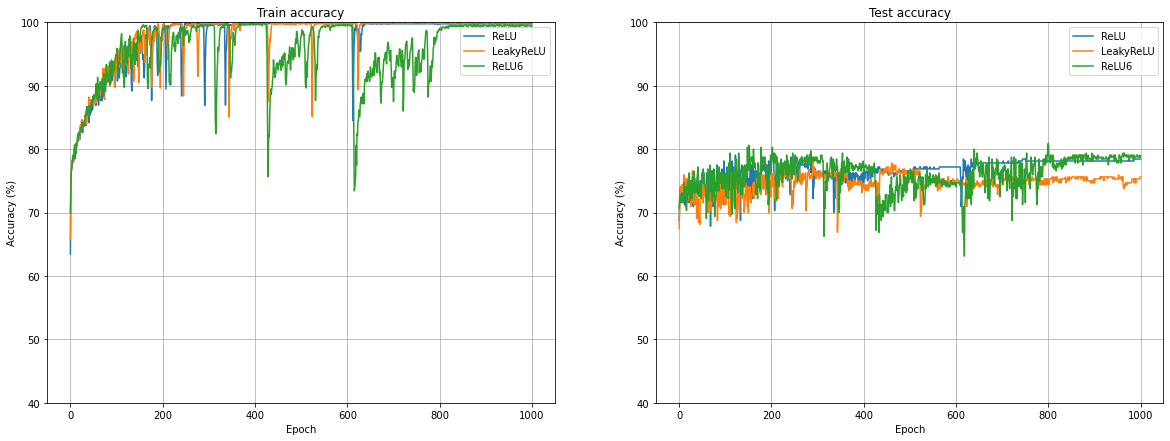

In [38]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(accuracy_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_test)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([40,100])
  ax[i].grid()

plt.show()

In [47]:
plt.rcParams.update({'font.size': 12})

In [48]:
x = np.linspace(-3, 3, 101)

def NNoutputx(af):
    activationFunc = getattr(torch, af)
    return activationFunc(torch.tensor(x))

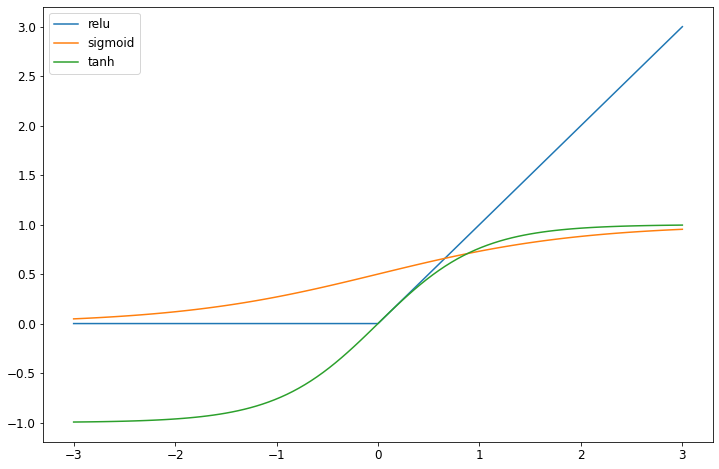

In [49]:
activation_functions = ['relu', 'sigmoid', 'tanh']
plt.figure(figsize = (12, 8))
for af in activation_functions:
    plt.plot(x, NNoutputx(af), label = af)

plt.legend()
plt.show()

In [50]:
def NNoutput(af):
    activationFunc = getattr(torch.nn, af)
    return activationFunc()(torch.tensor(x))

In [51]:
activation_functions = ['ReLU', 'ReLU6', 'LeakyReLU']
plt.figure(figsize = (12, 8))
for af in activation_functions:
    plt.plot(x, NNoutputx(af), label = af)

plt.legend()
plt.show()

AttributeError: module 'torch' has no attribute 'ReLU'

<Figure size 864x576 with 0 Axes>